<a href="https://colab.research.google.com/github/Hrenani/some_problem/blob/main/Neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification,make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from mlxtend.plotting import plot_decision_regions

import __main__

(1000, 2) (1000,)


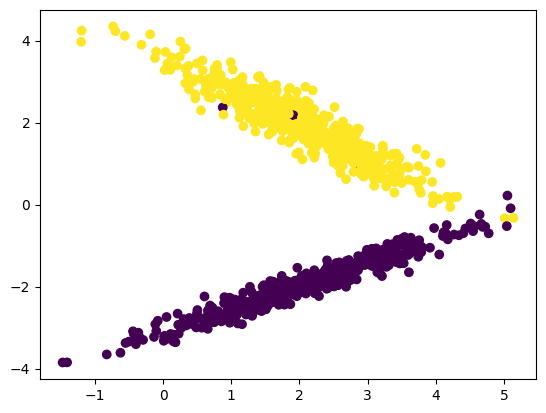

In [2]:
X,y = make_classification(n_samples=1000,n_features=2,
                          n_redundant = 0,n_clusters_per_class = 1,
                          class_sep = 2.0,
                          n_classes = 2, random_state = 42)
print(X.shape,y.shape)

plt.scatter(X[:,0], X[:, 1], c = y)

In [3]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [4]:
model = LogisticRegression()
model.fit(x_train,y_train)
model.predict(x_test)
model.score(x_test,y_test)

0.995

In [5]:
model.intercept_,model.coef_

(array([-0.11755523]), array([[0.12544129, 3.26456379]]))

#  Neuron (from Scratch)

#AF

In [6]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [7]:
def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [8]:
def relu(x):
  return np.maximum(0,x)

##loss

In [9]:
def bce(y,y_hat):
  return np.mean(-(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))

In [10]:
def mse(y,y_hat):
  return np.mean((y-y_hat)**2)

##Accuracy

In [11]:
def accuracy(y,y_hat, t = 0.5):
  y_hat = np.where(y_hat<t,0,1)
  acc = np.sum(y==y_hat)/len(y)
  return acc

# Neuron

In [12]:
class Neuron1:
  def __init__(self,in_features, af = None,loss_fn = mse,verbose= True,n_iter = 100,eta = 0.1):
    self.in_features = in_features
    self.af = af
    self.w = np.random.randn(in_features,1)
    self.b = np.random.randn()
    self.loss_fn = loss_fn
    self.n_iter = n_iter
    self.eta = eta
    self.verbose = verbose
    self.loss_hist = []
    self.w_grad ,self.b_grad  = None,None



  def predict(self,x):
    y_hat = x@self.w +self.b
    y_hat = y_hat if self.af is None else self.af(y_hat)
    return y_hat

  def __repr__(self):
    return f'Neuron({self.in_features}, {self.af.__name__})'

  def parameters(self):
    return {'w':self.w, 'b':self.b}

  def gradient_descent(self):
    self.w -= self.w_grad* self.eta
    self.b -= self.b_grad* self.eta

  def gradient(self,x,y,y_hat):
    self.w_grad = (x.T@(y_hat-y))/len(y)
    self.b_grad = (y_hat-y).mean()

  def fit(self,x,y):
    for i in range(self.n_iter):
      y_hat = self.predict(x)
      loss = self.loss_fn(y,y_hat)
      self.loss_hist.append(loss)
      self.gradient(x,y,y_hat)
      self.gradient_descent()
      if self.verbose & (i%10 == 0):
        print(f'Iter = {i}, Loss={loss}')



In [13]:
neuron1 = Neuron1(in_features = 2,af = sigmoid)
a = neuron1.predict(X)
print(a.shape)
print(neuron1)
print(neuron1.parameters())

(1000, 1)
Neuron(2, sigmoid)
{'w': array([[-1.01009997],
       [-1.36235058]]), 'b': 0.6833805809350079}


In [14]:
neuron1.fit(x_train,y_train[:,None])
neuron1.parameters()

Iter = 0, Loss=0.765984842074013
Iter = 10, Loss=0.23945822350554422
Iter = 20, Loss=0.06296839524423305
Iter = 30, Loss=0.034608809448721335
Iter = 40, Loss=0.02502693047154146
Iter = 50, Loss=0.020398739193246994
Iter = 60, Loss=0.01770374878538279
Iter = 70, Loss=0.015946910226809805
Iter = 80, Loss=0.014712431666480102
Iter = 90, Loss=0.01379757583048417


{'w': array([[-0.22723152],
        [ 1.7648812 ]]),
 'b': 0.8539367594392365}

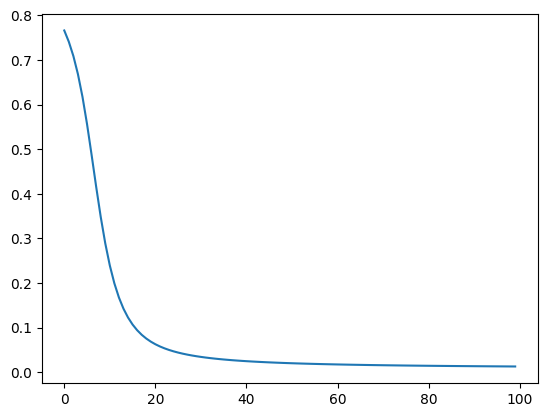

In [15]:
plt.plot(neuron1.loss_hist)

### Evaluation

In [16]:
y_hat = neuron1.predict(x_test)
accuracy(y_test[:,None],y_hat,t = 0.5)

0.995

<Axes: >

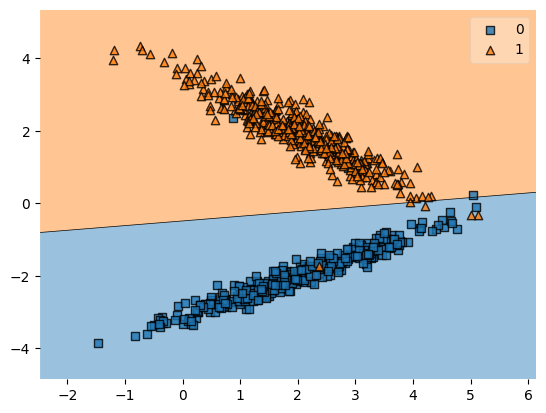

In [17]:
plot_decision_regions(x_train,y_train,clf = neuron1)

In [21]:
class MLP:
  def __init__(self,hidden_layer_sizes,hidden_activation = "relu",
               output_size = 1,output_activation = 'sigmoid',
               n_iter = 1000,loss_fn = bce , eta = 0.1):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.hidden_activation = hidden_activation
    self.output_size = output_size
    self.output_activation = output_activation
    self.n_iter = n_iter
    self.loss_fn = loss_fn
    self.eta = eta

  def _init_weights(self):
    self.ws,self.bs = [],[]
    all_layers = [self.input_size] + self.hidden_layer_sizes + [self.output_size]
    num_layers = len(all_layers)
    for i in range(1,num_layers):
      w = np.random.randn(all_layers[i-1], all_layers[i])
      b = np.random.randn(all_layers[i])
      self.ws.append(w)
      self.bs.append(b)

  def activation_function(self,X,activation):
    if activation == 'relu':
      return np.maximum(0,X)
    elif activation == 'sigmoid':
      return 1/(1+np.exp(-X))
    else:
      raise ValueError("invalid activation function.")

  def predict(self,X):
    self.hs = []
    self.as_ = []
    for i,(w,b) in enumerate(zip(self.ws[:-1],self.bs[:-1])):
      a = self.as_[i-1].copy() if i>0 else X.copy()
      self.hs.append(a @ w +b)
      self.as_.append(self.activation_function(self.hs[i],self.hidden_activation))
    y = self.activation_function(self.as_[-1] @ self.ws[-1] + self.bs[-1],self.output_activation)
    return y

  def fit(self,X,y):
    n,self.input_size = X.shape
    self._init_weights()
    for _ in range(self.n_iter):
      y_hat = self.predict(X)
      loss = self.loss_fn(y,y_hat)
      self.gradient_descent(X,y,y_hat)
      print(loss)


  def gradient_descent(self,X,y,y_hat):
    delta = y_hat - y
    for j in range(len(self.ws)-1,0,-1):
      w_grad = (self.as_[j-1].T @ delta) / len(y)
      b_grad = delta.mean(0)
      self.ws[j]  -= self.eta * w_grad
      self.bs[j] -= self.eta  * b_grad
      delta = (delta @ self.ws[j].T) * (self.activation_function(self.hs[j-1],self.hidden_activation))


  def activation_derivative(self,X,activation):
    if activation == 'relue':
      return np.where(X>0,1,0)
    elif activation == 'sigmoid':
      sigmoid = self.activation_function(X,'sigmoid')
    else:
      raise ValueError("Invalid activation function")

In [22]:
mlp = MLP([4,3],output_size=1)

In [23]:
X,y = make_classification(n_samples=1000,n_features=2,
                          n_redundant = 0,n_clusters_per_class =1,class_sep = 2,
                          n_classes = 2, random_state = 42)

mlp.fit(X,y[:,None])

1.9999759278312381
1.075556070000644
1.037605522991616
1.0035599939589277
0.9705638708270765
0.9363398648932796
0.8982085084821829
0.852036471908286
0.7905498968444138
0.7012685827784692
0.5672899283635856
0.3907036974977053
0.2344553924895688
0.16610109166127296
0.14796379914379718
0.14149624437262026
0.13730729528444954
0.13365897032034485
0.13027116599574248
0.12705123873894253
0.12400543376956989
0.12116904059895789
0.11851865781930745
0.11605474540889794
0.11376142098844999
0.11162346057571716
0.1096173188310123
0.10772567663837984
0.10595326918479231
0.10428962636876399
0.10272518856145982
0.10125158794387988
0.09985662211230957
0.09853480190208762
0.09728420536216303
0.09609945084459355
0.09497573501352809
0.09390441949180854
0.0928769597106838
0.09189840536383204
0.0909637183326151
0.09006652617984708
0.08920675058613883
0.08838521875052127
0.08759958913809808
0.08684769318624691
0.08612457657922866
0.08542962004868083
0.08476272541276632
0.08411978123605587
0.08350051216383696

<Axes: >

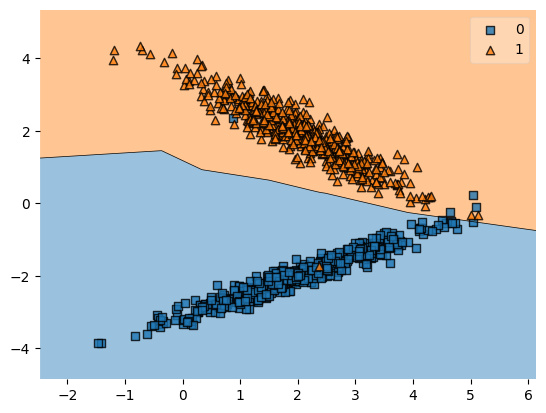

In [24]:
plot_decision_regions(X,y,mlp)

##XOR

###activation functions

In [25]:
def relu(x):
  return np.maximum(0,x)

In [27]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

### loss

In [28]:
def bce(y,y_hat):
  return np.mean(-(y * np.log(y_hat) + (1-y)*np.log(1-y_hat)))

In [29]:
def mse(y,y_hat):
  return np.mean((y-y_hat)**2)

### Accuracy

In [30]:
def Accuracy(y,y_hat,t = 0.5):
  y_hat = np.where(y_hat<t,0,1)
  acc = np.sum(y == y_hat) / len(y)
  return acc

In [51]:
def mlp_xor(X,w1,b1,w2,b2):
  hidden_output = np.matmul(X,w1) + b1
  activation_output = relu(hidden_output)
  output_layer = sigmoid(np.matmul(activation_output, w2) + b2)
  return output_layer, hidden_output, activation_output

In [52]:
#Data
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [53]:
#define the initial weights and biases
np.random.seed(42)
w1 = np.random.rand(2,2)
b1 = np.random.rand(1,2)
w2 = np.random.rand(2,1)
b2 = np.random.rand(1)

learning_rate = 1
num_iterations = 10000

##Train

In [54]:
for i in range(num_iterations):
  y_hat,h,a = mlp_xor(X,w1,b1,w2,b2)

  loss = bce(y,y_hat)
  print(loss)

  delta_output = y_hat - y
  delta_hidden = (delta_output @ w2.T) * (h>0)

  w2_grad = a.T @ delta_output
  b2_grad = delta_output.mean(0)
  w1_grad = X.T @ delta_hidden
  b1_grad = delta_hidden.mean(0)

  w2 -= learning_rate * w2_grad
  b2 -= learning_rate * b2_grad
  w1 -= learning_rate * w1_grad
  b1 -= learning_rate * b1_grad

Streaming output truncated to the last 5000 lines.
0.0002306070325124932
0.0002305484140294039
0.00023048985979701663
0.00023043136954167156
0.00023037294299215163
0.00023031457987940474
0.00023025627993601653
0.0002301980428966821
0.0002301398684980674
0.00023009031754101766
0.00023009000423282878
0.0002300671285129588
0.0002301872245815083
0.0002301285326203566
0.00023006990638832576
0.00023001134559987607
0.00022995284997118887
0.00022989441922136
0.00022983605307101194
0.00022977775124282106
0.00022971951346190657
0.000229661339455275
0.00022960322895170933
0.00022954518168249077
0.00022948719738042711
0.00022942927578062998
0.0002293714166199597
0.00022931361963746943
0.00022925588457379435
0.00022919821117159612
0.00022914059917561797
0.00022912962720373264
0.00022923710774028645
0.00022917890233519085
0.00022912076184347736
0.00022906268598410292
0.0002290046744781899
0.00022894672704902545
0.0002288888434218398
0.00022883102332397278
0.00022877326648487373
0.0002287155726358515

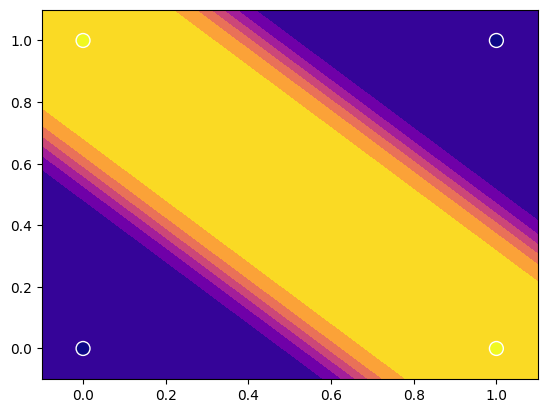

In [55]:
h = 0.001 # step size in the mesh
x_min, x_max = X[:,0].min() -0.1, X[:,0].max() + 0.1
y_min, y_max = X[:,1].min() - 0.1,X[:,1].max() + 0.1
x1, x2 = np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min,y_max,h))
Y,H,A =  mlp_xor(np.c_[x1.ravel(),x2.ravel()],w1,b1,w2,b2)
Y = Y.reshape(x1.shape)

plt.contourf(x1,x2,Y,cmap = 'plasma')
plt.scatter(X[:,0],X[:,1],c = y,s = 100,cmap = 'plasma',edgecolors='w')

In [56]:
A

array([[3.47284626, 0.        ],
       [3.46995147, 0.        ],
       [3.46705667, 0.        ],
       ...,
       [0.        , 4.0874254 ],
       [0.        , 4.09083744],
       [0.        , 4.09424948]])

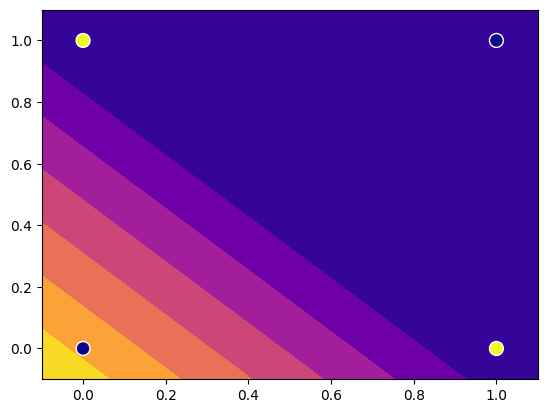

In [57]:
A0 = A[:,0].reshape(x1.shape)
plt.contourf(x1,x2,A0,cmap = 'plasma')
plt.scatter(X[:,0],X[:,1],c = y , s = 100, cmap = 'plasma', edgecolors='w')


#MLP(sklearn)

In [68]:
from sklearn.neural_network import MLPClassifier,MLPRegressor

from sklearn.datasets import load_diabetes,load_breast_cancer
from sklearn.preprocessing import StandardScaler

### `MLPClassifier()`

In [59]:
X,y = load_breast_cancer(return_X_y=True)
print(X.shape,y.shape)

(569, 30) (569,)


In [62]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [63]:
model = MLPClassifier(hidden_layer_sizes=(90),max_iter=1000,random_state=42)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.956140350877193

### `MLPRegressor()`

In [66]:
X,y = load_diabetes(return_X_y=True)
print(X.shape,y.shape)

(442, 10) (442,)


In [73]:
ys = StandardScaler().fit_transform(y[:,None])
ys.shape

(442, 1)

In [74]:
x_train,x_test,y_train,y_test = train_test_split(X,ys,test_size=0.2,random_state=42)


In [84]:
model = MLPRegressor(hidden_layer_sizes=(60),max_iter = 200000,learning_rate_init=0.03,random_state=42)
model.fit(x_train,y_train.ravel())
model.score(x_test,y_test)

0.500463028367296

In [85]:
[coef.shape for coef in model.coefs_]

[(10, 60), (60, 1)]

In [86]:
model.intercepts_

[array([-1.93851778e-01, -1.29644223e-01, -1.89123295e-01, -2.40831136e-01,
        -2.22132889e-01, -1.81863925e-01, -1.71953367e-01, -7.94754315e-02,
         4.03029984e-01,  1.52561966e-01, -2.69751190e-01, -2.44698885e-02,
         1.22450007e-01, -2.44896835e-01,  8.47509575e-02,  1.26690367e-01,
        -2.57006431e-01, -1.30647072e-01, -1.10674116e-02, -1.63063136e-02,
        -1.84725576e-01, -1.70187610e-01, -7.58437706e-02, -1.94047208e-01,
         1.30723030e-01, -2.56728269e-01,  6.89843251e-03,  1.37240564e-01,
        -2.71290538e-01, -1.44958082e-01,  1.00712371e-01,  1.20801631e-01,
        -2.35121664e-01,  1.98075254e-01, -2.30016518e-01, -2.19258083e-01,
         1.50451231e-01, -1.50793833e-01, -1.35117329e-01,  1.21281822e-01,
        -2.81017532e-01, -1.04179773e-01, -1.68958747e-01, -1.01007208e-01,
        -2.22644498e-01,  1.04530112e-01,  8.88972949e-02,  5.17541317e-02,
         1.29869497e-01, -1.84928599e-04, -2.41874713e-01, -6.79530490e-01,
         9.5

In [87]:
model.n_layers_

3

In [88]:
model.n_outputs_

1